### A Pinyin Input Method Engine (IME) for Chinese


In [1]:
# import the required libraries 
import json
import re 
import math

from pypinyin import lazy_pinyin
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

### 1. Training
#### 1.1. Data pre-processing

In [2]:
# read a Chinese word dictionary
# the dictionary provides data about words
with open('word.json','r', encoding = 'utf-8') as file_word:
    data_word = json.load(file_word)
    
# load the words
word_list = []

for word in data_word:
    word_list.append(word['word'])

print(f'The total words in the word list is {len(word_list)}.')

The total words in the word list is 320349.


In [3]:
# process the original texts
def text_process(corpus,label):
    sents = []
    
    # split the texts into sentences
    for doc in corpus:
        sent = re.split(r'[。？！；: ，“ ” \s]', doc[label])
        sents.extend(sent)
    
    # filter out all the non-hanzi characters 
    hanzi = re.compile(r'^[\u4e00-\u9fa5]{2,}$')
    texts = []
    for sent in sents:
        if hanzi.match(sent):
            texts.append(sent)
    return texts

# convert the texts into pinyin
def pinyin(texts):
    pinyin = []
    for text in texts:
        pinyin.append(lazy_pinyin(text))
    return pinyin

In [4]:
# read a news corpus from file
# the corpus provides data about phrases and sentences
with open('news2016zh.json','r',encoding = 'utf-8') as corpus:
    corpus_data = json.loads("[" + corpus.read().replace("}\n{", "},\n{") + "]")
    
# process with the corpus data 
train_texts = text_process(corpus_data[:10000],'content')

# combine the corpus texts with word list
train_texts.extend(word_list)
print(f'The total hanzi sequences for training is {len(train_texts)}.')

# convert the texts into pinyin
train_pinyin = pinyin(train_texts)

The total hanzi sequences for training is 896984.


#### 1.2. Count the parameters for HMM

In [5]:
# initial probability
# calculate of the probability of each hanzi as the beginning of a sequence

def count_init_prob(seqs_of_hanzi):
    initial_prob = {}

    for seq in tqdm.tqdm(seqs_of_hanzi):
        initial_prob[seq[0]] = initial_prob.get(seq[0], 0) + 1
    
    # normalize with log
    total = len(seqs_of_hanzi)
    for key in initial_prob.keys():
        initial_prob[key] = math.log(initial_prob.get(key) / total)
    
    save('initial_prob', initial_prob)

In [6]:
# transmission probability
# calculate the transmission probability between each two hanzi

def count_trans_prob(seqs_of_hanzi):
    trans_prob = {}
    
   
    for seq in tqdm.tqdm(seqs_of_hanzi):
        seq = [s for s in seq]
        # Add beginning and end marker to ensure each hanzi is counted in pairs
        seq.insert(0, 'BOS')
        seq.append('EOS')
        
        for index, hanzi in enumerate(seq):
            if index:
                pre = seq[index - 1]
                if not trans_prob.get(hanzi, None):
                    trans_prob[hanzi] = {}
                trans_prob[hanzi][pre] = trans_prob[hanzi].get(pre, 0) + 1
            
    # normalize with log
    for hanzi in trans_prob.keys():
        total = sum(trans_prob.get(hanzi).values())
        for pre in trans_prob.get(hanzi).keys():
            trans_prob[hanzi][pre] = math.log(trans_prob[hanzi].get(pre) / total)
     
    save('trans_prob', trans_prob)

In [7]:
# emission probability
# calculate the probability of each pinyin corresponding to a hanzi

def count_emiss_prob(seqs_of_hanzi,seqs_of_pinyin):
    emiss_prob = {}
    
    for seq_hanzi,seq_pinyin in tqdm.tqdm(zip(seqs_of_hanzi,seqs_of_pinyin)):
        for hanzi, pinyin in zip(seq_hanzi, seq_pinyin):
            if not emiss_prob.get(hanzi, None):
                emiss_prob[hanzi] = {}
            emiss_prob[hanzi][pinyin] = emiss_prob[hanzi].get(pinyin, 0) + 1
            
    # normalize by log
    for hanzi in emiss_prob.keys():
        total = sum(emiss_prob.get(hanzi).values())
        for key in emiss_prob.get(hanzi):
            emiss_prob[hanzi][key] = math.log(emiss_prob[hanzi][key] / total)
     
    save('emiss_prob', emiss_prob)
    

In [8]:
# count the hanzi with same pronunciation (pinyin)
def count_pinyin_states():
    
    with open('emiss_prob.json') as f:
        emiss_prob = json.load(f)
        
    data = {}
    for key in emiss_prob.keys():
        for pinyin in emiss_prob.get(key):
            if not data.get(pinyin, None):
                data[pinyin] = []
            data[pinyin].append(key)
    
    with open('pinyin_states.json', 'w') as f:
        json.dump(data, f)

In [9]:
def save(filename, data):
    with open(filename + '.json', 'w') as f:
        json.dump(data, f, indent=2)

In [10]:
count_init_prob(train_texts)
count_trans_prob(train_texts)
count_emiss_prob(train_texts,train_pinyin)
count_pinyin_states()

100%|███████████████████████████████| 896984/896984 [00:04<00:00, 223638.56it/s]
896984it [00:02, 341849.34it/s]


### 2. Decode with viterbi algorithm

In [11]:
def read(filename):
    with open(filename + '.json', 'r') as f:
        return json.load(f)

In [12]:
def pinyin_to_hanzi(seq):
    initial_prob = read('initial_prob')
    emiss_prob = read('emiss_prob')
    trans_prob = read('trans_prob')
    pinyin_states = read('pinyin_states')
    
    # set minimum value for smoothing
    min_f = -3.14e+100
    length = len(seq)
        
    viterbi = {}
    for i in range(length):
        viterbi[i] = {}
        
    # initialize the matrix
    for s in pinyin_states.get(seq[0]):
        viterbi[0][s] = (initial_prob.get(s, min_f) + 
                emiss_prob.get(s, {}).get(seq[0], min_f) + 
                trans_prob.get(s, {}).get('BOS', min_f), -1)
    
    for i in range(length - 1):
        # calculate the max probability of for each hidden state
        for s in pinyin_states.get(seq[i+1]):
            viterbi[i + 1][s] = max([(viterbi[i][pre][0] + emiss_prob.get(s, {}).get(seq[i+1], min_f)
            + trans_prob.get(s, {}).get(pre, min_f), pre) for pre in pinyin_states.get(seq[i])])
        
    for s in pinyin_states.get(seq[-1]):
        viterbi[length-1][s] = (viterbi[length-1][s][0] + trans_prob.get('EOS', {}).get(s, min_f),
                viterbi[length-1][s][1] )
    
    # Backtracking 
    words = [None] * length

    words[-1] = max(viterbi[length - 1], key=viterbi[length - 1].get)
        
    for n in range(length-2, -1, -1):
        words[n] = viterbi[n+1][words[n+1]][1]
        
    return ''.join(w for w in words)

In [13]:
# test 
print(pinyin_to_hanzi(['wo','hui','shuo','zhong','wen']))
print(pinyin_to_hanzi(['zi','ran','yu','yan','chu','li']))
print(pinyin_to_hanzi(['shang','e','biao','pi','shou','sun']))

我会说中文
自然语言处理
上额标疲瘦损


### 3. Test and evaluation

In [14]:
# news corpus for test dataset
news_texts = text_process(corpus_data[10000:10100],'content')
news_pinyin = pinyin(news_texts)

print(f'The total hanzi sequences in news test set is: {len(news_texts)}.')

The total hanzi sequences in news test set is: 6406.


In [15]:
# wiki corpus for test dataset 
with open('wiki_01','r',encoding = 'utf-8') as wiki:
    wiki_data = json.loads("[" + wiki.read().replace("}\n{", "},\n{") + "]")
    
wiki_texts = text_process(wiki_data[:30],'text')
wiki_pinyin = pinyin(wiki_texts)

print(f'The total hanzi sequences in wiki test set is: {len(wiki_texts)}.')

The total hanzi sequences in wiki test set is: 6585.


In [16]:
# predict the possible hanzi sequence 
def predict(seq_of_pinyin):
    pred_texts = []
    for seq in tqdm.tqdm(seq_of_pinyin):
        pred_texts.append(pinyin_to_hanzi(seq))
    return pred_texts

In [56]:
# evaluate the model performance
def evaluate(pred_texts,gold_texts,corpus):
    correct = 0
    total = 0
    accuracy = []
    
    for pred_seq, gold_seq in zip(pred_texts, gold_texts):
        total += len(gold_seq)
        same_count = 0
        for i in range(len(gold_seq)):
            if gold_seq[i] == pred_seq[i]:
                correct +=1
                same_count += 1
        accuracy.append(same_count/len(gold_seq))
        
    general_accuracy = correct/ total
    
    print(f'The accuracy on {corpus} corpus is: {general_accuracy:.3%}')
    return accuracy

In [57]:
# test on news corpus
news_pred_texts = predict(news_pinyin)
news_accuracy = evaluate(news_texts,news_pred_texts,'news')

The accuracy on news corpus is: 80.773%


In [58]:
# test on wiki corpus
wiki_pred_texts = predict(wiki_pinyin)
wiki_accuracy = evaluate(wiki_texts,wiki_pred_texts,'wiki')

The accuracy on wiki corpus is: 80.579%


In [28]:
# count the length of texts 
def texts_length(texts):
    count_len = {}
    for text in texts:
        length = len(text)
        count_len[length] = count_len.get(length,0)+1

    length = sorted(count_len.keys())
    count = []
    for l in length:
        count.append(count_len[l])

    return length,count

In [29]:
n_length, n_count = texts_length(news_texts)
w_length, w_count = texts_length(wiki_texts)

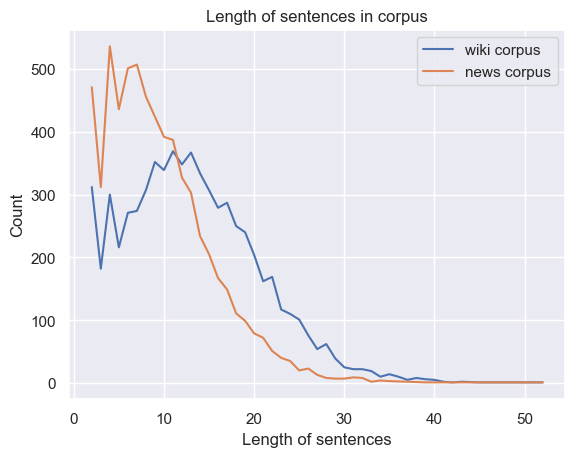

In [33]:
sns.lineplot(x = w_length,y = w_count, label = 'wiki corpus')
sns.lineplot(x = n_length,y = n_count, label = 'news corpus')
plt.legend()
plt.xlabel('Length of sentences')
plt.ylabel('Count')
plt.title('Length of sentences in corpus')
plt.show()

In [59]:
def accuracy_length(texts,pred_accuracy):
    len_acc = {}
    text_length = []
    for text in texts:
        text_length.append(len(text))
        
    for length, accuracy in zip(text_length, pred_accuracy):
        if length not in len_acc:
            len_acc[length] = []
        len_acc[length].append(accuracy)

    average = {length: sum(accuracy)/len(accuracy) for length, accuracy in len_acc.items()}
    
    length = sorted(average.keys())
    avg_accuracy = []
    for l in length:
        avg_accuracy.append(average[l])
    return length,avg_accuracy

wiki_length, wiki_avg_accuracy = accuracy_length(wiki_texts,wiki_accuracy)
news_length, news_avg_accuracy = accuracy_length(news_texts,news_accuracy)

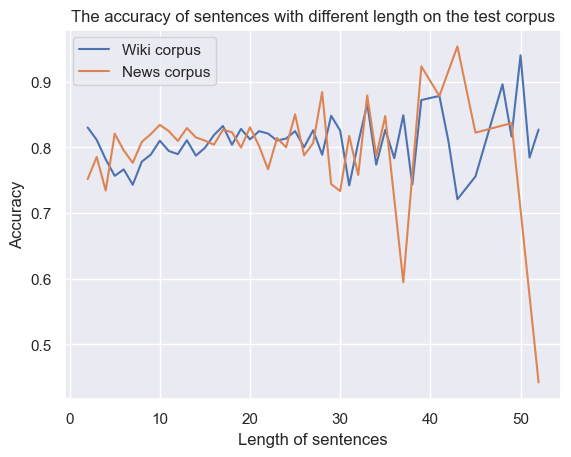

In [60]:
sns.lineplot(x = wiki_length,y = wiki_avg_accuracy,label = 'Wiki corpus')
sns.lineplot(x = news_length, y = news_avg_accuracy,label = 'News corpus')
plt.legend()
plt.xlabel('Length of sentences')
plt.ylabel('Accuracy')
plt.title('The accuracy of sentences with different length on the test corpus')
plt.show()